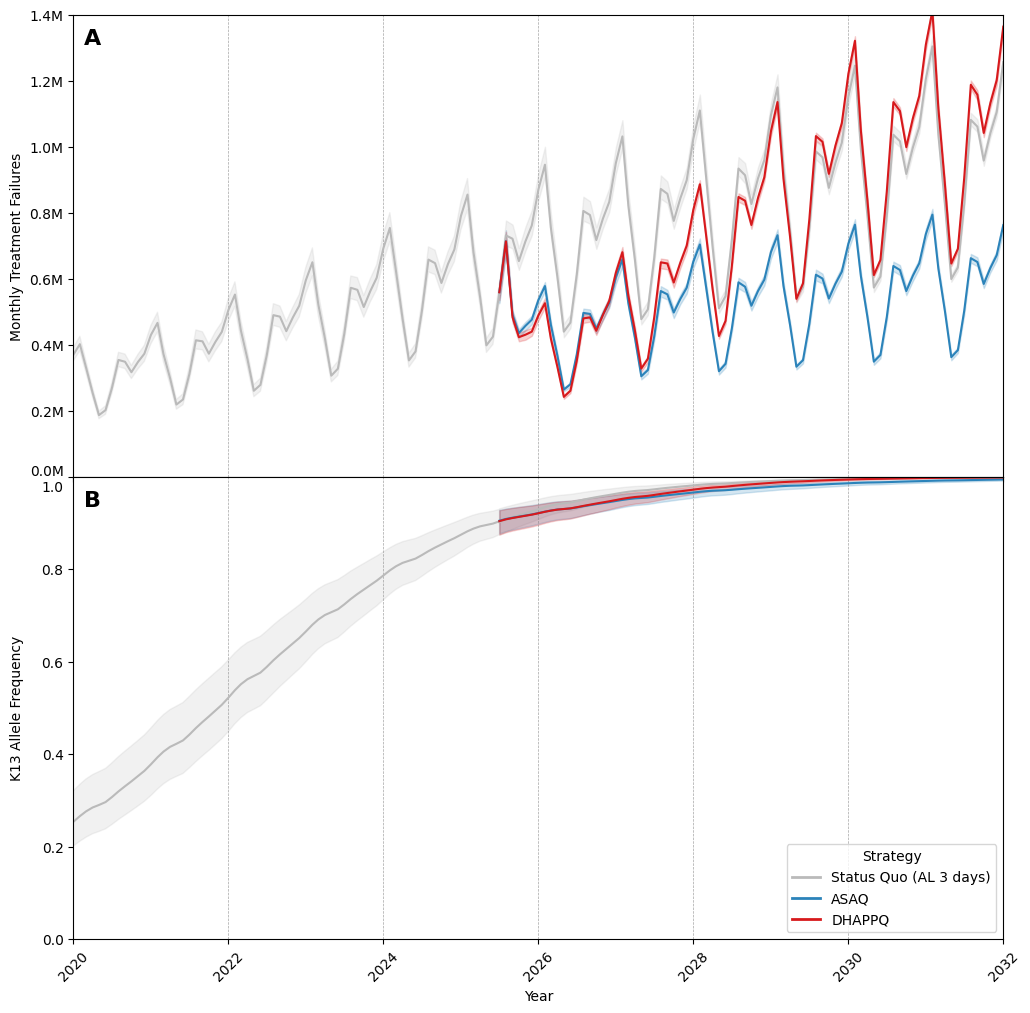

<Figure size 640x480 with 0 Axes>

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import pandas as pd
from matplotlib.lines import Line2D

filtered_combined_data = pd.read_csv("./data/fig4_data.csv")


# Adjust the y-axis to show values in millions
def millions_formatter(x, pos):
    return f'{x * 1e-6:.1f}M'  # Formats in millions with one decimal point

# Define the color palette for the two periods and strategies
palette_after = {'asaq': '#2b83ba', 'dhappq': '#d7191c', 'status_quo': '#bababa'}
cold_color = '#bababa'  # Color for 'Before Sep 2024'

# Define the year locator for x-axis
locator = mdates.YearLocator(2)

# Load the data
# monthly_data = pd.read_csv('../raw_data/monthly_data_parallel.csv')
# filtered_combined_data = monthly_data[monthly_data["scenario"].isin(["status_quo", "asaq", "dhappq"])]
filtered_combined_data.loc[:, 'date'] = pd.to_datetime(filtered_combined_data['date'])
critical_point = pd.to_datetime("2025-07-01")

# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12), sharex=True)

# Plot 1: Monthly Treatment Failures
sns.lineplot(
    ax=ax1, x="date", y="total_treatmentfailures",
    data=filtered_combined_data[filtered_combined_data["date"] <= critical_point],
    color=cold_color, legend=False, errorbar=("pi", 90) 
)

sns.lineplot(
    ax=ax1, x="date", y="total_treatmentfailures", hue="scenario",
    data=filtered_combined_data[filtered_combined_data["date"] >= critical_point],
    palette=palette_after, errorbar=("pi", 90),
)

ax1.set_xlim(pd.to_datetime("2020-01-01"), pd.to_datetime("2032-01-01"))
ax1.set_ylim([0, 1.4e6])
ax1.set_xlabel('Year')
ax1.set_ylabel('Monthly Treatment Failures')
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax1.yaxis.set_major_formatter(mticker.FuncFormatter(millions_formatter))
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, which='both', axis='x', linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
ax1.text(0.03, 0.97, 'A', transform=ax1.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')
# ax1.legend(title="Strategy", loc="upper left")
ax1.legend().remove()
yticks = ax1.get_yticks()
yticks = yticks[1:]  # Remove the first label
ax1.set_yticks(yticks)

# Plot 2: K13 Allele Frequency
sns.lineplot(
    ax=ax2, x="date", y="k13_frequency",
    data=filtered_combined_data[filtered_combined_data["date"] <= critical_point],
    color=cold_color, legend=False, errorbar=("pi", 90)
)
sns.lineplot(
    ax=ax2, x="date", y="k13_frequency", hue="scenario",
    data=filtered_combined_data[filtered_combined_data["date"] >= critical_point],
    palette=palette_after, errorbar=("pi", 90)
)

ax2.set_xlim(pd.to_datetime("2020-01-01"), pd.to_datetime("2032-01-01"))
ax2.set_ylim([0, 1])
ax2.set_xlabel('Year')
ax2.set_ylabel('K13 Allele Frequency')
ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, which='both', axis='x', linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
ax2.text(0.03, 0.97, 'B', transform=ax2.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')
# ax2.legend(title="Strategy", loc="upper left")
# Get the current y-ticks
yticks = ax2.get_yticks()

# Get current labels and modify the last one
yticks_labels = [item.get_text() for item in ax2.get_yticklabels()]
if yticks_labels:  # Ensure there are labels to modify
    yticks_labels[-1] = '0.0M\n1.0'

# Set fixed tick positions and modified labels
ax2.set_yticks(yticks)  # Ensure tick positions remain consistent
ax2.set_yticklabels(yticks_labels)



# -------------------------------
# Create a custom legend using scenario_mapping
# -------------------------------
scenario_mapping = {
  "status_quo": {"label": "Status Quo (AL 3 days)", "color": "#bababa", "position": 0},
    "asaq" : {"label": "ASAQ", "color": "#2b83ba", "position": 0},
    "dhappq" : {"label": "DHAPPQ", "color": "#d7191c", "position": 0},
}

# Build custom legend handles and labels.
# (Optionally, you might filter these based on which scenarios appear in your data.)
custom_handles = []
custom_labels = []
for key, mapping in scenario_mapping.items():
    custom_handles.append(Line2D([0], [0], color=mapping["color"], lw=2))
    custom_labels.append(mapping["label"])

# Add the custom legend to one of your axes (here, we add it to ax1)
ax2.legend(handles=custom_handles, labels=custom_labels, title="Strategy", loc="lower right")

# Adjust layout to remove gaps between subplots
plt.subplots_adjust(hspace=0)
plt.show()
plt.savefig("fig4.png", dpi=300, bbox_inches='tight')